In [2]:
%autosave 60
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
import random
import matplotlib.pyplot as plt

Autosaving every 60 seconds


Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#convert to dim 4 (channels_first) for conv latter 
x_train = x_train.reshape(np.shape(x_train)[0],1,28,28)
x_test = x_test.reshape(np.shape(x_test)[0],1,28,28)

noise_factor = 0.4
#random noise from a normal (Gaussian) distribution
x_train_noise = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noise = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
#limit the values in the interval [0,1]
x_train_noise = np.clip(x_train_noise, a_min = 0, a_max = 1)
x_test_noise = np.clip(x_test_noise, a_min = 0, a_max = 1)
#convert to dim 4 (channels_first) for conv latter 
x_train_noise = x_train_noise.reshape(np.shape(x_train_noise)[0],1,28,28)
x_test_noise = x_test_noise.reshape(np.shape(x_test_noise)[0],1,28,28)

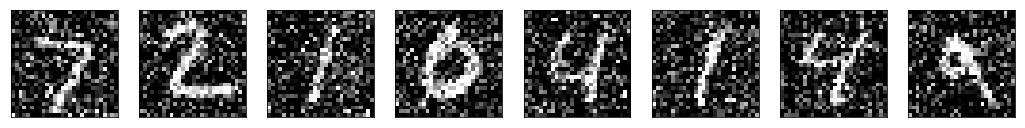

In [3]:
n = 8
plt.figure(figsize=(18, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
x_train_noise_flatten = x_train_noise.reshape(60000,784)
x_test_noise_flatten = x_test_noise.reshape(10000,784)

### random forest/logistic regression/SVM with noisy images

In [8]:
%%time
random_forest = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest.fit(x_train_noise_flatten, y_train)
score_rf_noise = random_forest.score(x_test_noise_flatten, y_test)
print("The accuracy of random forest on test data is",score_rf_noise)

The accuracy of random forest on test data is 0.7042
CPU times: user 12.7 s, sys: 234 ms, total: 12.9 s
Wall time: 12.9 s


In [11]:
%%time
#create logistic regression classifier using default value
logi_regr = LogisticRegression()
logi_regr.fit(x_train_noise_flatten, y_train)
logi_score = logi_regr.score(x_test_noise_flatten, y_test)
print(logi_score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8685
CPU times: user 2min 27s, sys: 1.03 s, total: 2min 28s
Wall time: 2min 28s


In [15]:
%%time
svm_classifier = svm.SVC(gamma=0.001)
svm_classifier.fit(x_train_noise_flatten,y_train)
svm_score = svm_classifier.score(x_test_noise_flatten, y_test)
print(svm_score)

0.904
CPU times: user 36min 31s, sys: 3.3 s, total: 36min 35s
Wall time: 36min 35s


In [12]:
%%time
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_noise_flatten, y_train)
lda_score = lda.score(x_test_noise_flatten, y_test)
print("The accuracy of lda on for original data is",lda_score)

The accuracy of lda on for original data is 0.8493
CPU times: user 54.8 s, sys: 1min 6s, total: 2min 1s
Wall time: 8.17 s


### use convolutional autoencoder to denoise

In [14]:
autoencoder = Sequential()
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
autoencoder.fit(x_train_noise, x_train,
                epochs=70,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/70
 2304/60000 [>.............................] - ETA: 5s - loss: 12.0637

/usr/local/src/incubator-mxnet/python/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0078125). Is this intended?
  force_init=force_init)


60000/60000 [==============================] - 4s 65us/step - loss: 8.7246 - val_loss: 8.1085
Epoch 2/70
60000/60000 [==============================] - 4s 61us/step - loss: 7.9498 - val_loss: 8.0321
Epoch 3/70
60000/60000 [==============================] - 4s 61us/step - loss: 7.8858 - val_loss: 7.9790
Epoch 4/70
60000/60000 [==============================] - 4s 68us/step - loss: 7.8529 - val_loss: 7.9626
Epoch 5/70
60000/60000 [==============================] - 4s 69us/step - loss: 7.8341 - val_loss: 7.9398
Epoch 6/70
60000/60000 [==============================] - 4s 61us/step - loss: 7.8206 - val_loss: 7.9326
Epoch 7/70
60000/60000 [==============================] - 4s 61us/step - loss: 7.8105 - val_loss: 7.9277
Epoch 8/70
60000/60000 [==============================] - 4s 62us/step - loss: 7.8030 - val_loss: 7.9212
Epoch 9/70
60000/60000 [==============================] - 4s 61us/step - loss: 7.7963 - val_loss: 7.9213
Epoch 10/70
60000/60000 [==============================] - 4s 61us

In [27]:
print(np.shape(x_train_noise))
print(np.shape(x_test_noise))
autoencoder.summary()

(60000, 1, 28, 28)
(10000, 1, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 28, 28)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 14, 14)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 7, 7)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 7, 7)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32

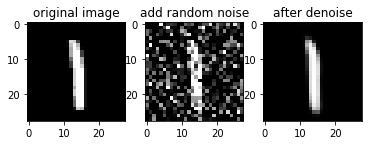

In [15]:
x_train_denoise = autoencoder.predict(x_train_noise)
x_test_denoise = autoencoder.predict(x_test_noise)
num = random.randint(0,10000)

plt.subplot(1, 3, 1);
plt.imshow(x_test[num].reshape(28,28),
           cmap ='gray')
plt.title('original image')
#display the same image after dimensionality reduction 
plt.subplot(1, 3, 2);
plt.imshow(x_test_noise[num].reshape(28,28),
           cmap ='gray')
plt.title('add random noise')
plt.subplot(1, 3, 3);
plt.imshow(x_test_denoise[num].reshape(28,28),
           cmap ='gray')
plt.title('after denoise')
plt.show()

In [ ]:
autoencoder.summary()

In [16]:
x_train_denoise_flatten = x_train_denoise.reshape(60000,784)
x_test_denoise_flatten = x_test_denoise.reshape(10000,784)

In [17]:
%%time
random_forest = RandomForestClassifier(n_estimators=10,bootstrap=True)
random_forest.fit(x_train_denoise_flatten, y_train)
score_rf_noise = random_forest.score(x_test_denoise_flatten, y_test)
print("The accuracy of random forest on test data is",score_rf_noise)

The accuracy of random forest on test data is 0.9332
CPU times: user 22.7 s, sys: 52 ms, total: 22.8 s
Wall time: 22.8 s


In [19]:
%%time
#create logistic regression classifier using default value
logi_regr = LogisticRegression()
logi_regr.fit(x_train_denoise_flatten, y_train)
logi_score = logi_regr.score(x_test_denoise_flatten, y_test)
print(logi_score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.916
CPU times: user 10min 14s, sys: 3.57 s, total: 10min 18s
Wall time: 10min 17s


In [20]:
%%time
svm_classifier = svm.SVC(gamma=0.001)
svm_classifier.fit(x_train_denoise_flatten,y_train)
svm_score = svm_classifier.score(x_test_denoise_flatten, y_test)
print(svm_score)

0.9304
CPU times: user 26min 43s, sys: 6.69 s, total: 26min 50s
Wall time: 26min 45s


In [18]:
%%time
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_denoise_flatten, y_train)
lda_score = lda.score(x_test_denoise_flatten, y_test)
print("The accuracy of lda on for original data is",lda_score)

The accuracy of lda on for original data is 0.876
CPU times: user 55.5 s, sys: 1min 5s, total: 2min 1s
Wall time: 8.68 s


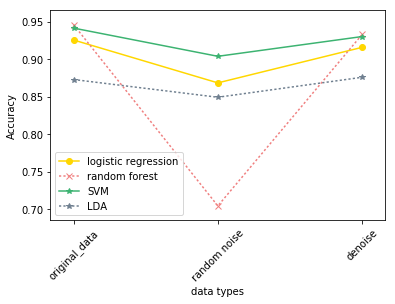

In [24]:
x_axis = ['original_data', 'random noise', 'denoise']
x = range(len(x_axis))
logistic_regression = [0.9258, 0.8685, 0.916]
random_forest = [0.9463, 0.7042, 0.9332]
svm = [0.9417, 0.904, 0.9304]
LDA = [0.873, 0.8493, 0.876]

plt.plot(x, logistic_regression,color='gold',linestyle='-',marker='o',label='logistic regression')
plt.plot(x,random_forest,color='lightcoral',linestyle=':',marker='x',label='random forest')
plt.plot(x,svm,color='mediumseagreen',linestyle='-',marker='*',label='SVM')
plt.plot(x,LDA,color='slategrey',linestyle=':',marker='*',label='LDA')

plt.xticks(x, x_axis, rotation=45)
plt.margins(0.08)
plt.subplots_adjust(bottom=0.15)
plt.xlabel('data types')
plt.ylabel('Accuracy')
#plt.title('The plot of classification accuracies of other machine learning methods')
plt.legend()
plt.show()